# Import data and libraries

In [1]:
library(ArchR)
library(dplyr)
library(tidyr)
library(parallel)
library(mclust)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
projdir = '/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis'

addArchRGenome("mm10")
addArchRThreads(threads = 45) 

inputFiles = c("/nas/homes/benyang/HiC/13_MultiOme/RawData/Aged/10x_analysis_5422-JL/Sample_5422-JL-1/atac_fragments.tsv.gz",
"/nas/homes/benyang/HiC/13_MultiOme/RawData/Aged_v2/atac_fragments.tsv.gz",
"/nas/homes/benyang/HiC/13_MultiOme/RawData/Young/10x_analysis_5644-JL/Sample_5644-JL-1/atac_fragments.tsv.gz",
"/nas/homes/benyang/HiC/13_MultiOme/RawData/6098-JL/10x_analysis_6098-JL/Sample_6098-JL-1/atac_fragments.tsv.gz")
names(inputFiles) = c("Aged","Aged_v2","Young","Young_v2")

Setting default genome to Mm10.

Setting default number of Parallel threads to 45.



In [62]:
source(file.path(projdir,'ArchR_utilities.R'))

# Create ArchR object

In [23]:
ArrowFiles <- createArrowFiles(
    inputFiles = inputFiles,
    sampleNames = names(inputFiles),
    minTSS = 0, #Dont set this too high because you can always increase later
    minFrags = 0,
    QCDir = file.path(projdir, "output", "QualityControl"),
    addTileMat = TRUE,
    addGeneScoreMat = TRUE,
    force = TRUE
)

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

ArchR logging to : ArchRLogs/ArchR-createArrows-85775b76fc23-Date-2022-11-26_Time-20-34-47.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2022-11-26 20:34:47 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-85775b76fc23-Date-2022-11-26_Time-20-34-47.log



In [121]:
# doubScores <- addDoubletScores(
#     input = ArrowFiles,
#     k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
#     knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search with doublet projection.
#     dimsToUse = 1:30,
#     LSIMethod = 1,
#     UMAPParams = list(n_neighbors =30, min_dist = 0.3, metric = "cosine", verbose =FALSE)
# )

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-8577474e79e-Date-2022-11-26_Time-22-48-19.log
If there is an issue, please report to github with logFile!

2022-11-26 22:48:20 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-11-26 22:48:20 : Aged_v2 (1 of 4) :  Computing Doublet Statistics, 0.006 mins elapsed.



In [24]:
projAging1 <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/output",
  copyArrows = TRUE #This is recommened so that if you modify the Arrow files you have an original copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

Validating Arrows...

Getting SampleNames...



Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 
3 
4 


Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,

In [25]:
projAging1$Age = sapply(projAging1$Sample, function(x) ifelse(grepl("Aged", x), "Aged", "Young"))

In [4]:
#saveRDS(projAging1, file.path(projdir, "output", "projAging1-01.RDS"))
#saveArchRProject(ArchRProj = projAging1, outputDirectory = file.path(projdir, "Save-projAging1-01"), load = FALSE)
projAging1 = readRDS(file.path(projdir, "output", "projAging1-01.RDS"))

In [10]:
table(df$Age, df$Sample)

       
          Aged Aged_v2  Young Young_v2
  Aged  546602  616973      0        0
  Young      0       0 336851   494289

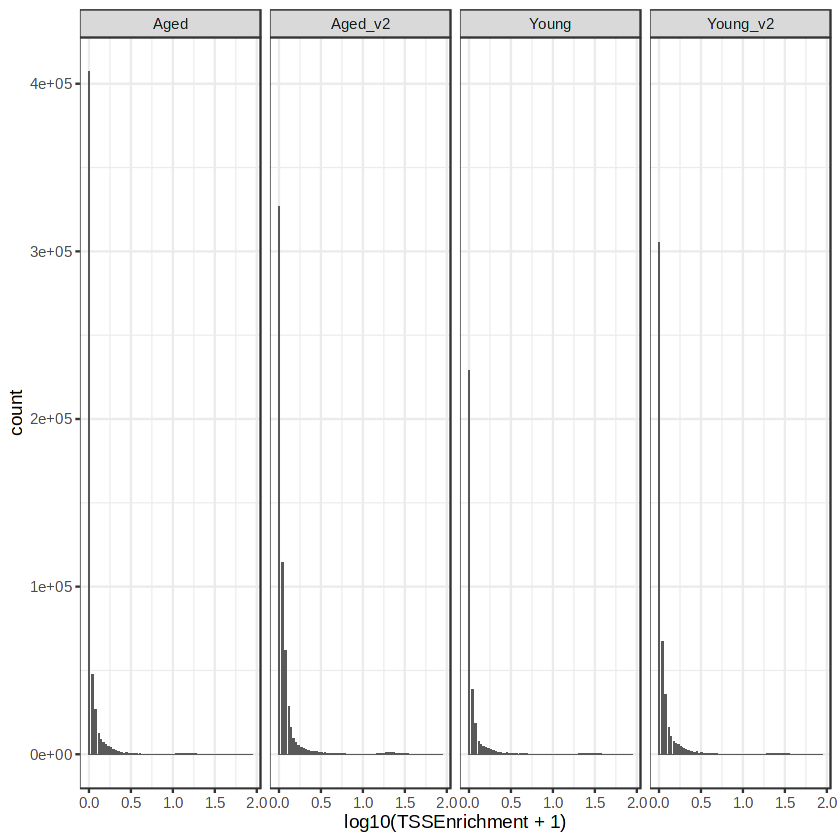

In [51]:
ggplot(as.data.frame(df), aes(x=log10(TSSEnrichment + 1))) + 
    facet_grid(cols = vars(Sample)) +
    geom_histogram(bins = 100) +
    theme_bw() + theme(text = element_text(family = "Arial")) 
ggsave(file.path(projdir, "output", "QualityControl", "Sample_TSSEnrichment_histogram.png"), dpi=300, width=8, height=3)

Warning message:
“Removed 32 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 32 rows containing non-finite values (stat_bin).”


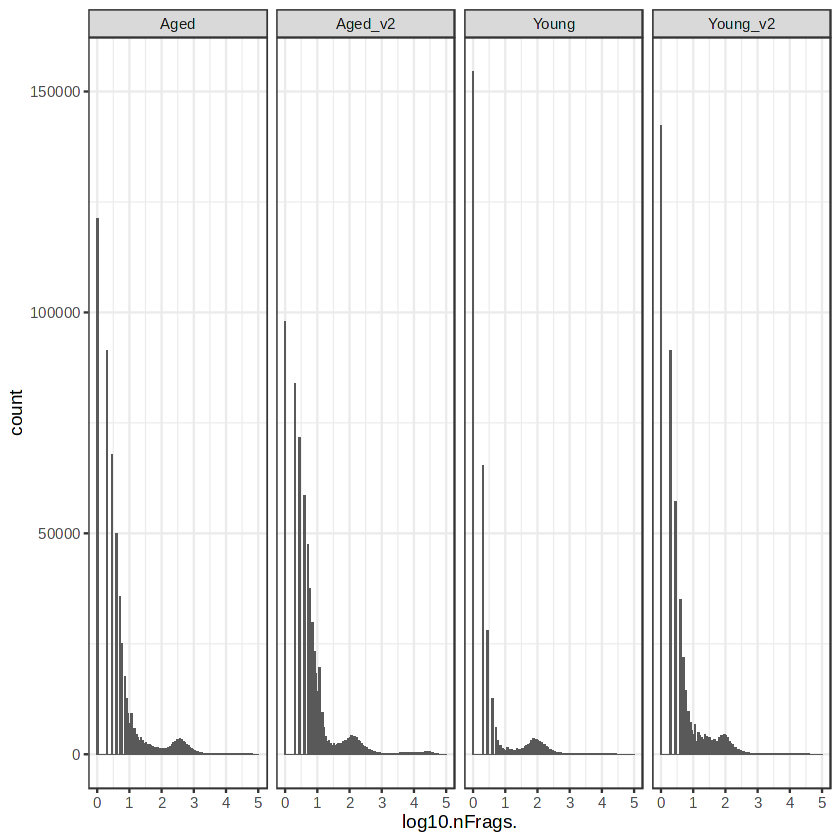

In [54]:
ggplot(as.data.frame(df), aes(x=log10.nFrags.)) + 
    facet_grid(cols = vars(Sample)) +
    geom_histogram(bins = 100) +
    theme_bw() + theme(text = element_text(family = "Arial")) 
ggsave(file.path(projdir, "output", "QualityControl", "Sample_log10nFrags_histogram.png"), dpi=300, width=8, height=3)

# Sample QC

## Check that GMM clustering will work for thresholding

In [5]:
df <- projAging1@cellColData 
df

DataFrame with 1994715 rows and 14 columns
                            Sample TSSEnrichment ReadsInTSS ReadsInPromoter
                             <Rle>       <array>    <array>         <array>
Aged_v2#CGGTTCCGTCATCATC-1 Aged_v2         6.943       6062           27939
Aged_v2#ACGCCACAGGGCTAAA-1 Aged_v2         2.862        951            5216
Aged_v2#GTGCTCAAGGGCCATC-1 Aged_v2        15.218      12673           49847
Aged_v2#AGGTTACTCGAGGAGT-1 Aged_v2        17.301      14154           54105
Aged_v2#CATTTGTTCATGCAAC-1 Aged_v2        18.403      17267           62546
...                            ...           ...        ...             ...
Young#GTTGCGGGTTAGGTTG-1     Young             0          0               0
Young#TAAGTAGCAGGCCTTG-1     Young             0          0               0
Young#TAGTGGCGTTGGATAT-1     Young             0          0               0
Young#TTCACTGTCTGGCATG-1     Young             0          0               0
Young#TTCCTTCTCACACAGT-1     Young           

**Only cluster on cells with at least 100 unique fragments, otherwise low-quality cells dominate clustering**

In [47]:
proj.i <- df[df$Sample=='Aged_v2' & df$nFrags>1e2,]

depth.clust <- Mclust(log10(proj.i$nFrags + 1), G = 2)
TSS.clust <- Mclust(log10(proj.i$TSSEnrichment + 1), G = 2)

proj.i$depth_cluster <- depth.clust$classification
proj.i$depth_uncertainty <- depth.clust$uncertainty

proj.i$TSS_cluster <- TSS.clust$classification
proj.i$TSS_uncertainty <- TSS.clust$uncertainty

**Clustering seems to have worked**

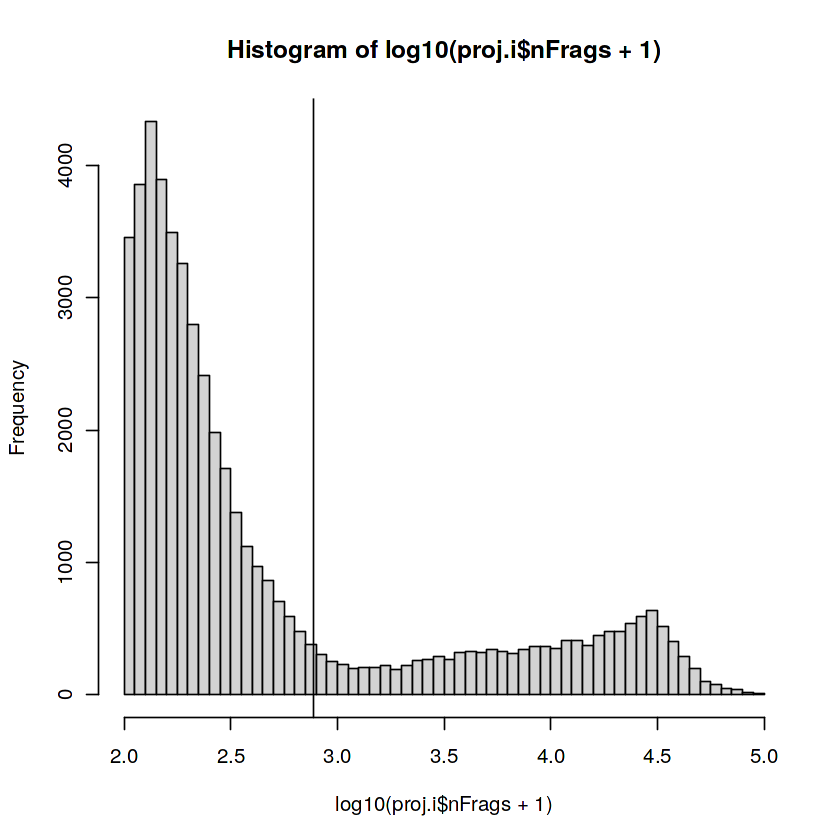

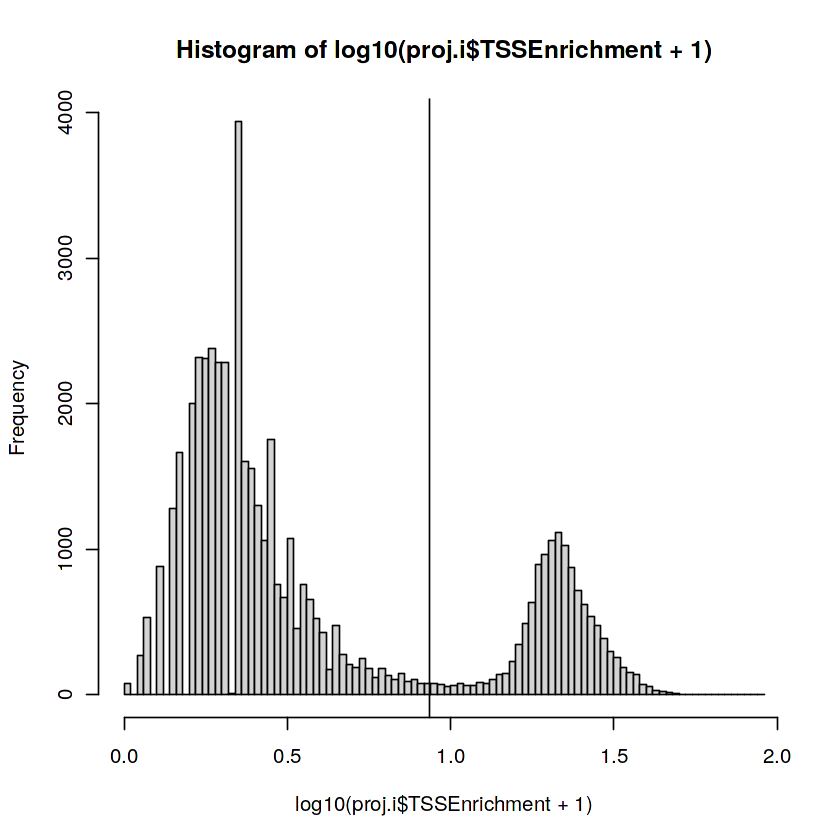

In [48]:
depth_thresh <- proj.i %>% as.data.frame() %>% filter(depth_cluster==2 & depth_uncertainty<0.05) %>% summarise(thresh = min(nFrags)) %>% pull(thresh)
TSS_thresh <- proj.i %>% as.data.frame() %>% filter(TSS_cluster==2 & depth_uncertainty<0.05) %>% summarise(thresh = min(TSSEnrichment)) %>% pull(thresh)

hist(log10(proj.i$nFrags + 1), breaks = 100)
abline(v=log10(depth_thresh + 1))
hist(log10(proj.i$TSSEnrichment + 1), breaks = 100)
abline(v=log10(TSS_thresh + 1))

**Visual inspection confirms clustering is valid**

In [53]:
depth_thresh; TSS_thresh;

[1] 771

[1] 7.624

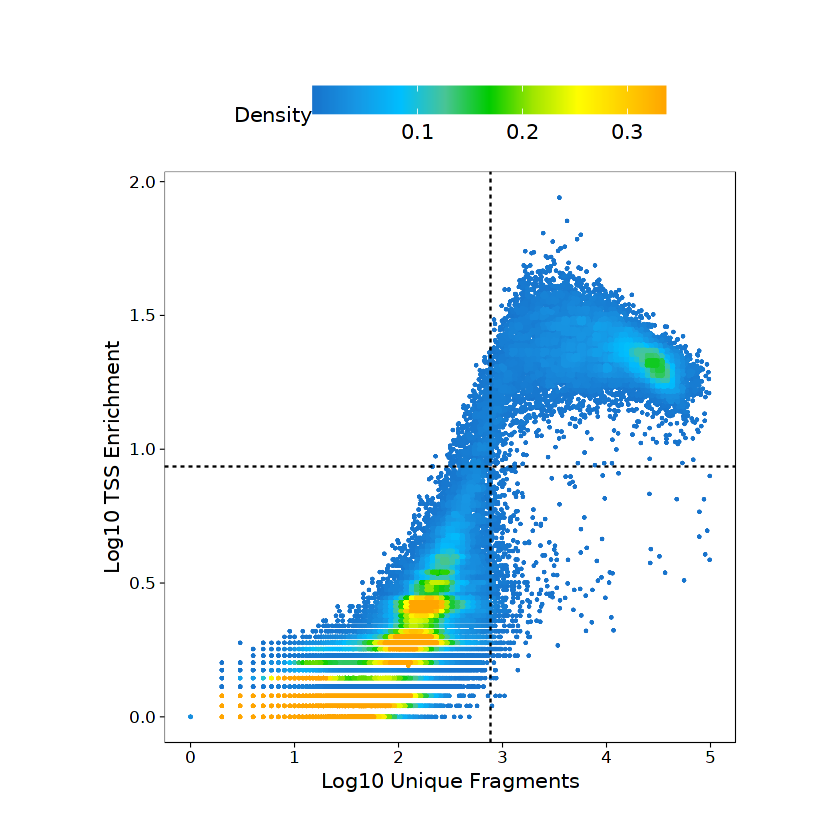

In [49]:
plot_qc(df[df$Sample=='Aged_v2',], nfrag_thresh = depth_thresh, tss_thresh = TSS_thresh)

## Use Mclust mixed gaussian modeling to set thresholds for TSS and nFrag

In [79]:
Mclust_outdir <- file.path(projdir, "output", "QualityControl", "Mclust_quality_filtering")
gmm_clustering(projAging1, minFrags = 1e2, outdir = Mclust_outdir)

**TSS thresholds are often inconsistent and too low, set manually**

### Reload the Mclust objects to filter the ArchR objects

In [86]:
list.depth <- list.files(pattern = "^df_depth", path = Mclust_outdir, full.names = TRUE)
df.depth <- do.call(rbind, lapply(list.depth, readRDS))

list.TSS <- list.files(pattern = "^df_TSS", path = Mclust_outdir, full.names = TRUE)
df.TSS <- do.call(rbind, lapply(list.TSS, readRDS))

In [92]:
df.depth %>% group_by(Sample) %>% filter(depth.cluster==2 & depth.cluster.uncertainty<0.05) %>% summarise(thresh = min(nFrags))
df.TSS %>% group_by(Sample) %>% filter(TSS.cluster==2 & TSS.cluster.uncertainty<0.05) %>% summarise(thresh = min(TSSEnrichment))

Sample,thresh
<chr>,<dbl>
Aged,2893
Aged_v2,771
Young,466
Young_v2,441


Sample,thresh
<chr>,<dbl>
Aged,3.521
Aged_v2,8.911
Young,5.422
Young_v2,8.416


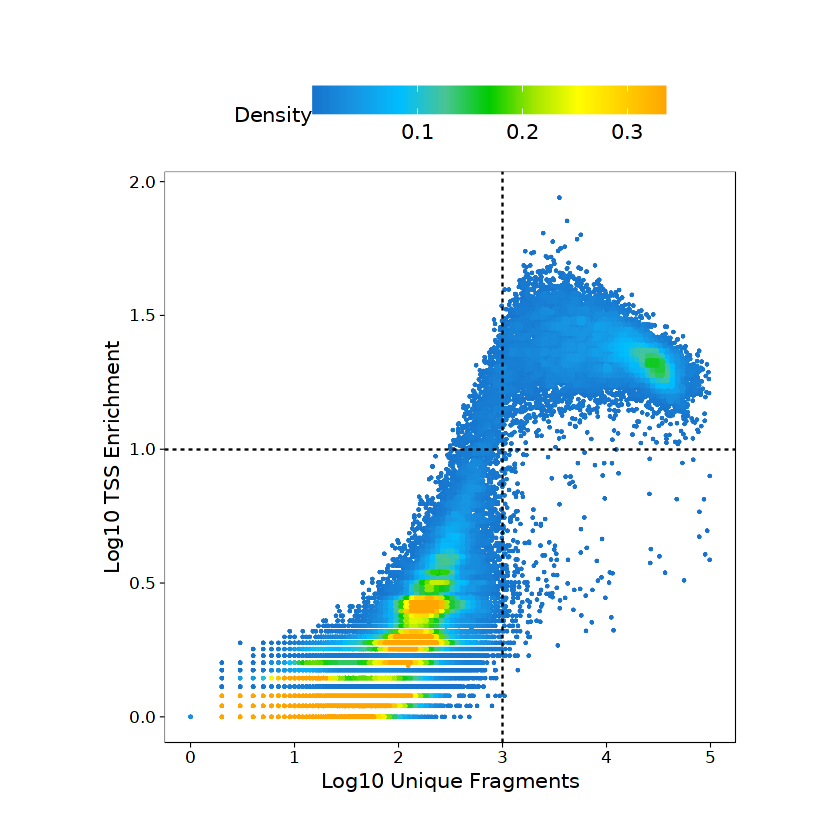

In [93]:
plot_qc(df[df$Sample=='Aged_v2',], nfrag_thresh = 1e3, tss_thresh = 9)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.0000  0.5122     Inf  1.2857     Inf      32 

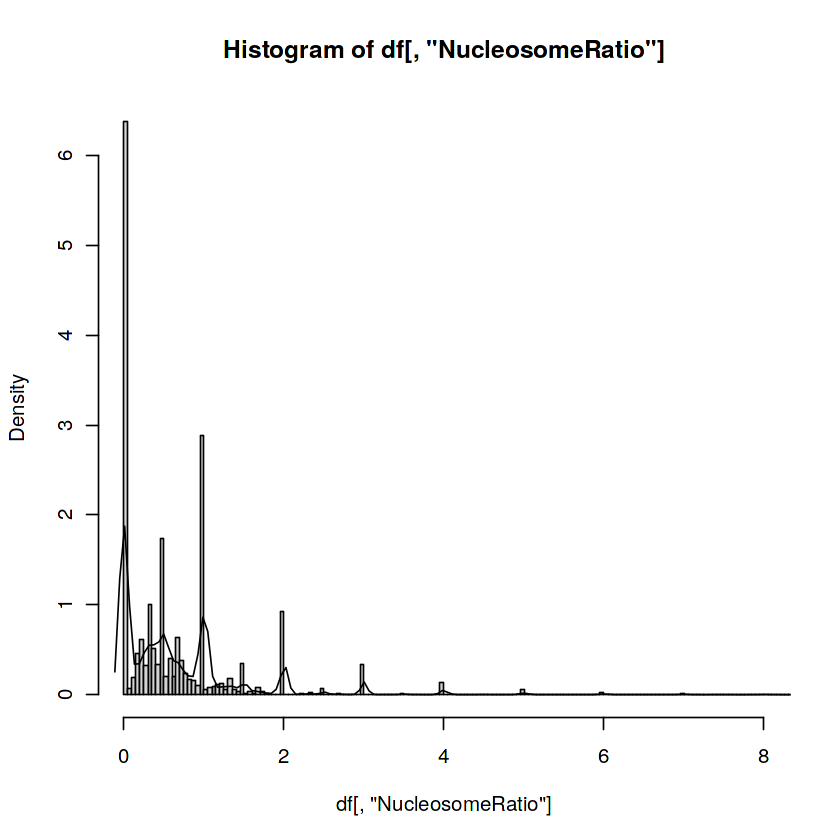

In [35]:
summary(df[,'NucleosomeRatio'])
hist(df[,'NucleosomeRatio'], freq = FALSE, breaks=500, xlim=c(0,8))
lines(density(df[,'NucleosomeRatio'], na.rm = TRUE), xlim=c(0,8))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.0000  0.0000  0.0222  0.0000  1.0000      32 

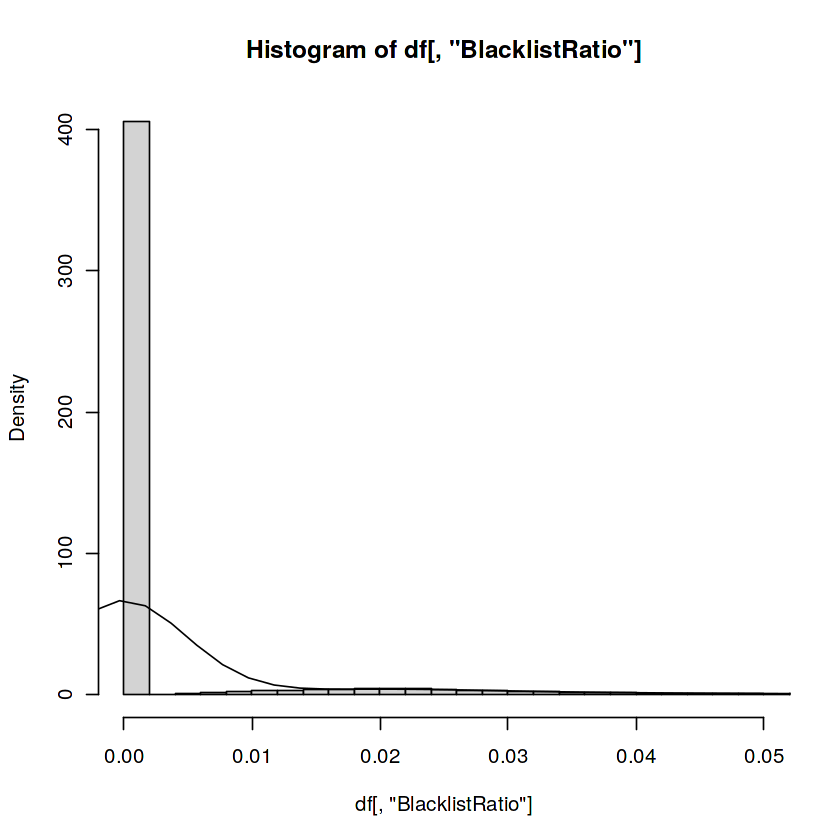

In [32]:
summary(df[,'BlacklistRatio'])
hist(df[,'BlacklistRatio'], freq = FALSE, breaks=500, xlim = c(0,0.05))
lines(density(df[,'BlacklistRatio'], na.rm = TRUE), xlim = c(0,0.05))

In [96]:
# cellsPass <- intersect(df.TSS$cellNames, df.depth$cellNames)

# cellsFail <-  projAging1$cellNames[!(projAging1$cellNames %in% cellsPass)]

## Manually set thresholds based on clustering

### Generate QC plots for paper

In [63]:
png(file.path(getOutputDirectory(projAging1), 'QualityControl', 'Aged_nfrag_tss_qc.png'), units='in', res=300, width=4, height=4)
plot_qc(df[df$Age=='Aged',], nfrag_thresh = 1e3, tss_thresh = 8)
dev.off()

png 
  2

In [64]:
png(file.path(getOutputDirectory(projAging1), 'QualityControl', 'Young_nfrag_tss_qc.png'), units='in', res=300, width=4, height=4)
plot_qc(df[df$Age=='Young',], nfrag_thresh = 1e3, tss_thresh = 8)
dev.off()

png 
  2

### Do the actual filtering

In [36]:
projAging2 <- projAging1[projAging1$nFrags>=1e3 & projAging1$TSSEnrichment>8 & projAging1$BlacklistRatio<0.05]

In [43]:
table(projAging2$Sample)


    Aged  Aged_v2    Young Young_v2 
    4302    11541     4991     6251 

### Doublet filtering

In [44]:
doubScores <- addDoubletScores(
    input = projAging2,
    k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
    knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search with doublet projection.
    dimsToUse = 1:30,
    LSIMethod = 1,
    useMatrix = "TileMatrix",
    corCutOff = 0.75,
    UMAPParams = list(n_neighbors =30, min_dist = 0.3, metric = "cosine", verbose =FALSE)
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-736554b619f7-Date-2022-12-21_Time-23-04-13.log
If there is an issue, please report to github with logFile!

2022-12-21 23:04:13 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-12-21 23:04:14 : Aged_v2 (1 of 4) :  Computing Doublet Statistics, 0.003 mins elapsed.

Aged_v2 (1 of 4) : UMAP Projection R^2 = 0.99908

Aged_v2 (1 of 4) : UMAP Projection R^2 = 0.99908

2022-12-21 23:10:16 : Aged (2 of 4) :  Computing Doublet Statistics, 6.042 mins elapsed.

Aged (2 of 4) : UMAP Projection R^2 = 0.99358

Aged (2 of 4) : UMAP Projection R^2 = 0.99358

2022-12-21 23:13:07 : Young_v2 (3 of 4) :  Computing Doublet Statistics, 8.893 mins elapsed.

Young_v2 (3 of 4) : UMAP Projection R^2 = 0.99715

Young_v2 (3 of 4) : UMAP Projection R^2 = 0.99715

2022-12-21 23:16:28 : Young (4 of 4) :  Computing Doublet Statistics, 12.246 mins elapsed.

Young (4 of 4) : UMAP Projection R^2 = 0.99686

Young (4 of 4) : UMAP Projection R^2 = 0.99686

ArchR lo

In [45]:
head(doubScores@cellColData)

DataFrame with 6 rows and 16 columns
                            Sample TSSEnrichment ReadsInTSS ReadsInPromoter
                             <Rle>       <array>    <array>         <array>
Aged_v2#GTGCTCAAGGGCCATC-1 Aged_v2        15.218      12673           49847
Aged_v2#AGGTTACTCGAGGAGT-1 Aged_v2        17.301      14154           54105
Aged_v2#CATTTGTTCATGCAAC-1 Aged_v2        18.403      17267           62546
Aged_v2#ATGTTTGAGCGATACT-1 Aged_v2        19.763      16288           57772
Aged_v2#TTTATGGAGCTTACTT-1 Aged_v2         15.33      11744           45647
Aged_v2#TGACCAAGTCATTACC-1 Aged_v2        17.789      15119           56255
                           ReadsInBlacklist     PromoterRatio  PassQC
                                    <array>           <array> <array>
Aged_v2#GTGCTCAAGGGCCATC-1             4370  0.25726952733879       1
Aged_v2#AGGTTACTCGAGGAGT-1             4390 0.280595575193702       1
Aged_v2#CATTTGTTCATGCAAC-1             4526 0.327438539179964       1
Aged_

In [46]:
saveRDS(doubScores, file.path(projdir, 'output', 'projAging2-01-doubScores.RDS'))

In [47]:
projAging2@cellColData$DoubletScore <- doubScores@cellColData[getCellNames(projAging2), 'DoubletScore']
projAging2@cellColData$DoubletEnrichment <- doubScores@cellColData[getCellNames(projAging2), 'DoubletEnrichment']

In [48]:
projAging2 = filterDoublets(projAging2, cutEnrich = 1, filterRatio = 1, cutScore = -Inf)

Filtering 2155 cells from ArchRProject!

	Aged_v2 : 1331 of 11541 (11.5%)

	Aged : 185 of 4302 (4.3%)

	Young_v2 : 390 of 6251 (6.2%)

	Young : 249 of 4991 (5%)



In [49]:
summary(projAging2@cellColData$DoubletEnrichment)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.3000  0.7333  1.0987  1.5333  7.6500 

In [50]:
saveRDS(projAging2, file.path(projdir, "output", "projAging2-01-filtered.RDS"))

In [51]:
table(projAging2$Sample)


    Aged  Aged_v2    Young Young_v2 
    4117    10210     4742     5861 

## QC metrics plotting by age

In [52]:
p1 = plotFragmentSizes(projAging2, groupBy="Age", pal=ggsci::pal_nejm()(2))
p2 = plotTSSEnrichment(projAging2, groupBy="Age", pal=ggsci::pal_nejm()(2))

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-73656475f777-Date-2022-12-21_Time-23-28-11.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-73656475f777-Date-2022-12-21_Time-23-28-11.log

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-736539aba063-Date-2022-12-21_Time-23-32-58.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-736539aba063-Date-2022-12-21_Time-23-32-58.log



In [65]:
ggsave(p1, filename=file.path(getOutputDirectory(projAging2), "Plots", "Fragment_sizes_qc.pdf"), dpi=300, width=4, height=4)
ggsave(p2, filename=file.path(getOutputDirectory(projAging2), "Plots", "TSS_enrichment_qc.pdf"), dpi=300, width=4, height=4)

png(file.path(getOutputDirectory(projAging2), "Plots", "Fragment_sizes_qc.png"), res=300, units='in', width=4, height=4)
p1
dev.off()


png(file.path(getOutputDirectory(projAging2), "Plots", "TSS_enrichment_qc.png"), res=300, units='in', width=4, height=4)
p2
dev.off()

png 
  2

png 
  2

In [66]:
saveArchRProject(ArchRProj = projAging2, outputDirectory = file.path(projdir,"Save-projAging2-01"), dropCells = TRUE, load = FALSE)

Copying ArchRProject to new outputDirectory : /nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/Save-projAging2-01

Copying Arrow Files...

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 17): Aged

Copying Other Files (2 of 17): Aged_v2

Copying Other Files (3 of 17): ATAC_res0.2_cluster_markersGS.RDS

Copying Other Files (4 of 17): Embeddings

Copying Other Files (5 of 17): IterativeLSI

Copying Other Files (6 of 17): Plots

Copying Other Files (7 of 17): projAging1-01.RDS

Copying Other Files (8 of 17): projAging2-01-doubScores.RDS

Copying Other Files (9 of 17): projAging2-01-filtered.RDS

Copying Other Files (10 of 17): projAging2-01.RDS

Copying Other Files (11 of 17): projAging3-01-scoreMat.RDS

Copying Other Files (12 of 17): projAging3-01.RDS

Copying Other Files (13 of 17): QualityControl

Copying Other Files (14 of 17): RNAIntegration

Copying Other Files (15 of 17): Save-projAging1-01

Copying Other Files (16 